In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#### Loading the data

In [2]:
dataset = pd.read_csv('facies_vectors.csv')
dataset.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


#### Checking the presence of null values and the data type.

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 11 columns):
Facies       4149 non-null int64
Formation    4149 non-null object
Well Name    4149 non-null object
Depth        4149 non-null float64
GR           4149 non-null float64
ILD_log10    4149 non-null float64
DeltaPHI     4149 non-null float64
PHIND        4149 non-null float64
PE           3232 non-null float64
NM_M         4149 non-null int64
RELPOS       4149 non-null float64
dtypes: float64(7), int64(2), object(2)
memory usage: 356.6+ KB


In [4]:
#Creating a column with the facies labels
def litologia(facies):
    if facies == 1: return 'Nonmarine sandstone'
    if facies == 2: return 'Nonmarine coarse siltstone'
    if facies == 3: return 'Nonmarine fine siltstone'
    if facies == 4: return 'Marine siltstone and shale'
    if facies == 5: return 'Mudstone (limestone)'
    if facies == 6: return 'Wackestone (limestone)'
    if facies == 7: return 'Dolomite'
    if facies == 8: return 'Packstone-grainstone (limestone)'
    if facies == 9:
        return 'Phylloid-algal bafflestone (limestone)'

In [5]:
dataset['Labels_char'] = dataset.Facies.apply(litologia)
dataset.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Labels_char
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,Nonmarine fine siltstone
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,Nonmarine fine siltstone
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,Nonmarine fine siltstone
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,Nonmarine fine siltstone
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,Nonmarine fine siltstone


In [6]:
def phi_N(delta_phi,phi_nd):
    delta_phi = np.asarray(delta_phi); phi_nd = np.asarray(phi_nd)
    return (delta_phi+(2*phi_nd))/2

def phi_D(delta_phi,phi_nd):
    delta_phi = np.asarray(delta_phi); phi_nd = np.asarray(phi_nd)
    return (-delta_phi+(2*phi_nd))/2

In [7]:
#Calculating density and neutron porosities
dataset['PHID'] = phi_D(dataset.DeltaPHI,dataset.PHIND)
dataset['PHIN'] = phi_N(dataset.DeltaPHI,dataset.PHIND)

In [8]:
#Creating a function to transform formations into qualitative variables
def formation_to_num (formation):
    formation_num = np.ones(len(formation))*-999
    aux=0
    for i in sorted(dataset.Formation.unique()):
        formation_num[dataset[dataset.Formation==i].index.values] = aux
        aux+=1
    return formation_num

In [9]:
dataset['Formation_num'] = formation_to_num(dataset.Formation)

In [10]:
PE_null = dataset[dataset.PE.isnull()]
data = dataset[~dataset.PE.isnull()]

In [11]:
#Selecting the columns that will be used to build the model
cols = ['DeltaPHI', 'RELPOS', 'Formation_num', 'GR',
       'ILD_log10', 'PHID', 'PHIND', 'PHIN', 'NM_M']

#### Separating data into training and testing to execute the hold-out cross validation method.

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data[cols], data['PE'], test_size=0.33)

## PCA

In [14]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA()
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

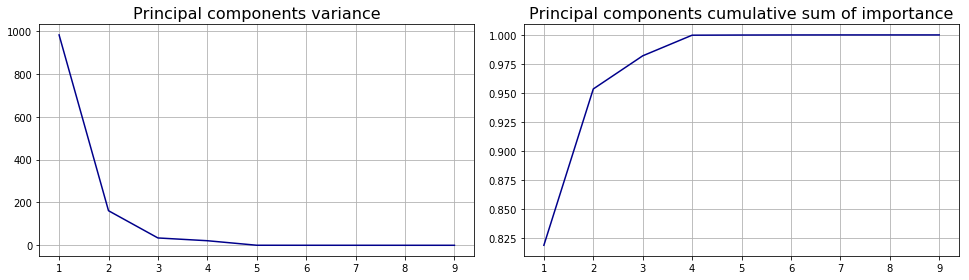

In [16]:
fig,axes = plt.subplots(ncols=2,figsize=(14,4))

n_comp = np.arange(1,len(pca.explained_variance_ratio_)+1)

axes[0].plot(n_comp,pca.explained_variance_, c='darkblue')
axes[0].set_title('Principal components variance',fontsize=16)


axes[1].plot(n_comp,np.cumsum(pca.explained_variance_ratio_), c = 'darkblue')
axes[1].set_title('Principal components cumulative sum of importance',fontsize=16)

axes[1].grid()
axes[0].grid()



fig.tight_layout()

#### Using only the four principal components to train the model 

In [17]:
X_pca_train = pca.transform(X_train)[:,:4]

## Random Forest 

#### Selecting the optimal parameters

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [19]:
X_pca_test = pca.transform(X_test)[:,:4]

### Tree depth

In [20]:
mse_test_depth = []
mse_train_depth = []
for i in range(1, 51):
    r_forest = RandomForestRegressor(criterion='mse', max_depth = i)
    arv = r_forest.fit(X_pca_train, y_train)
    mse_test_depth.append(mean_squared_error(y_test, arv.predict(X_pca_test)))
    mse_train_depth.append(mean_squared_error(y_train, arv.predict(X_pca_train)))

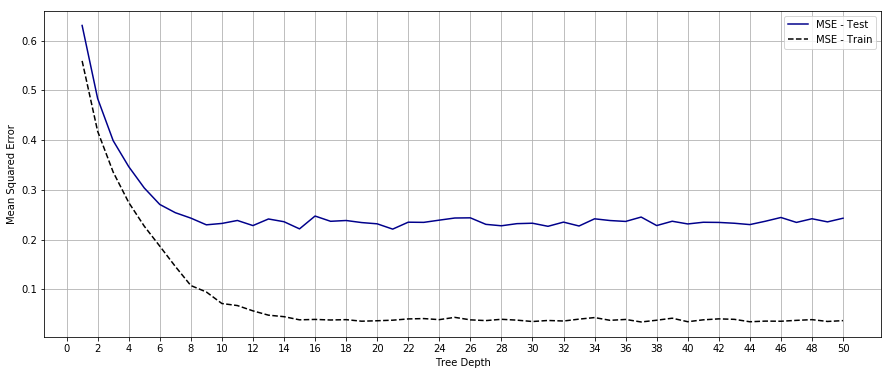

In [21]:
plt.figure(figsize = ((15,6)))
plt.plot(np.arange(1, len(mse_test_depth)+1), np.asarray(mse_test_depth), c='darkblue', label = 'MSE - Test')
plt.xlabel('Tree Depth')
plt.ylabel('Mean Squared Error')

plt.plot(np.arange(1, len(mse_test_depth)+1), np.asarray(mse_train_depth), c='black', label = 'MSE - Train', ls='--')

x_ticks=np.arange(0,51,2)
y_ticks=np.arange(0,max(mse_test_depth),5)
plt.xticks(x_ticks)
plt.legend()
plt.grid()

#fig.tight_layout()
plt.show()

#### Tree Depth: 12

In [22]:
mse_test_leafnodes = []
mse_train_leafnodes = []
for i in range(2, 101):
    r_forest = RandomForestRegressor(criterion='mse', max_leaf_nodes = i, max_depth = 12)
    arv = r_forest.fit(X_pca_train, y_train)
    mse_test_leafnodes.append(mean_squared_error(y_test, arv.predict(X_pca_test)))
    mse_train_leafnodes.append(mean_squared_error(y_train, arv.predict(X_pca_train)))

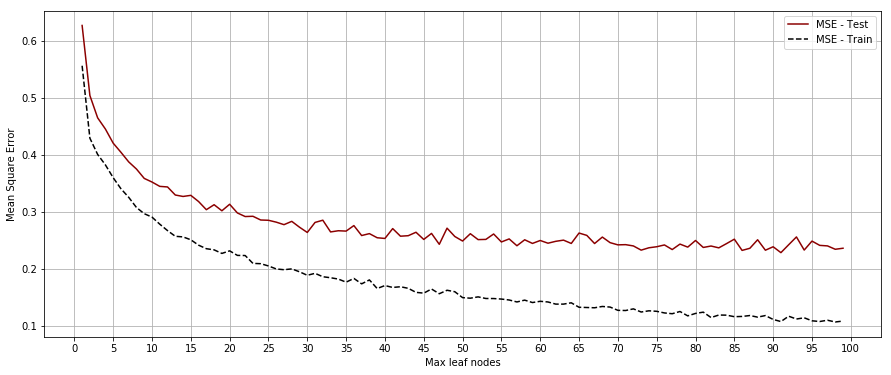

In [23]:
plt.figure(figsize = ((15,6)))
plt.plot(np.arange(1, len(mse_test_leafnodes)+1), np.asarray(mse_test_leafnodes), c='darkred', label = 'MSE - Test')
plt.xlabel('Max leaf nodes')
plt.ylabel('Mean Square Error')

plt.plot(np.arange(1, len(mse_test_leafnodes)+1), np.asarray(mse_train_leafnodes), c='black', label = 'MSE - Train', ls='--')

x_ticks=np.arange(0,101,5)
y_ticks=np.arange(15,max(mse_test_leafnodes),5)
plt.xticks(x_ticks)
plt.legend()
plt.grid()

#fig.tight_layout()
plt.show()

#### Max leaf nodes: 36

In [24]:
mse_test_minsample = []
mse_train_minsample = []
for i in range(1, 101):
    r_forest = RandomForestRegressor(criterion='mse', max_leaf_nodes = 36 , max_depth = 12, min_samples_leaf = i)
    arv = r_forest.fit(X_pca_train, y_train)
    mse_test_minsample.append(mean_squared_error(y_test, arv.predict(X_pca_test)))
    mse_train_minsample.append(mean_squared_error(y_train, arv.predict(X_pca_train)))

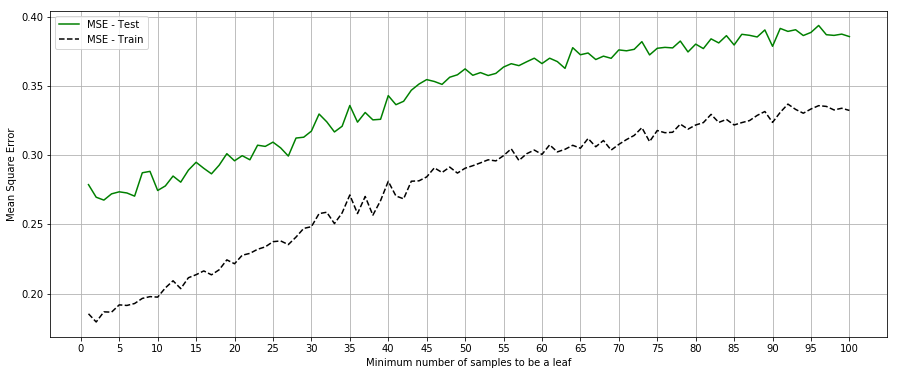

In [25]:
plt.figure(figsize = ((15,6)))
plt.plot(np.arange(1, len(mse_test_minsample)+1), np.asarray(mse_test_minsample), c='green', label = 'MSE - Test')
plt.xlabel('Minimum number of samples to be a leaf')
plt.ylabel('Mean Square Error')

plt.plot(np.arange(1, len(mse_train_minsample)+1), np.asarray(mse_train_minsample), c='black', label = 'MSE - Train', ls='--')

x_ticks=np.arange(0,101,5)
#y_ticks=np.arange(15,max(mse_test),0.5)
#plt.yticks(y_ticks)
plt.xticks(x_ticks)
plt.legend()
plt.grid()

#fig.tight_layout()
plt.show()

#### Minimum number of samples to be a leaf: 9

In [26]:
mse_test_estimators = []
mse_train_estimators = []
for i in range(1, 101):
    r_forest = RandomForestRegressor(criterion='mse', max_leaf_nodes = 36 , max_depth = 12, 
                                     min_samples_leaf = 9, n_estimators = i)
    arv = r_forest.fit(X_pca_train, y_train)
    mse_test_estimators.append(mean_squared_error(y_test, arv.predict(X_pca_test)))
    mse_train_estimators.append(mean_squared_error(y_train, arv.predict(X_pca_train)))

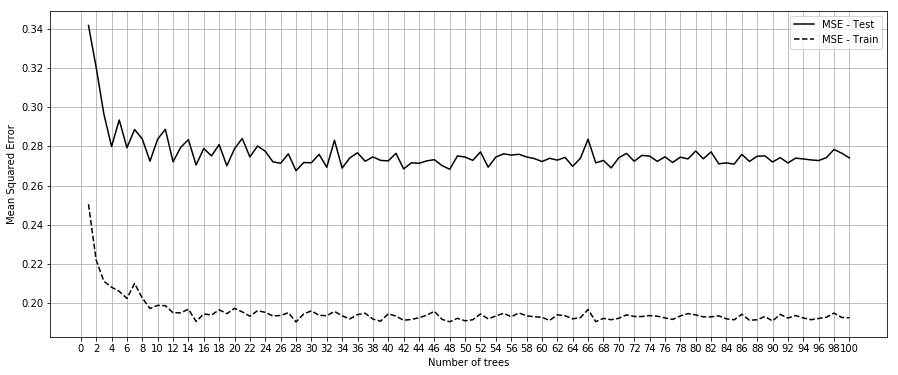

In [27]:
plt.figure(figsize = ((15,6)))
plt.plot(np.arange(1, len(mse_test_estimators)+1), np.asarray(mse_test_estimators), c='black', label = 'MSE - Test')
plt.xlabel('Number of trees')
plt.ylabel('Mean Squared Error')

plt.plot(np.arange(1, len(mse_test_estimators)+1), np.asarray(mse_train_estimators), c='black', label = 'MSE - Train', ls='--')

x_ticks=np.arange(0,101,2)
y_ticks=np.arange(0,max(mse_test_estimators),5)
plt.xticks(x_ticks)
plt.legend()
plt.grid()

#fig.tight_layout()
plt.show()

#### Number os trees: 42

### Retraining the model with the selected parameters

In [28]:
r_forest = RandomForestRegressor(criterion='mse', max_leaf_nodes = 36 , max_depth = 12, 
                                 min_samples_leaf = 9, n_estimators = 42)
arv = r_forest.fit(X_pca_train, y_train)

In [29]:
print(f'Mean Squared Error (Train): {mean_squared_error(y_train,arv.predict(X_pca_train))}')
print(f'Mean Squared Error (Test): {mean_squared_error(y_test,arv.predict(X_pca_test))}')

Mean Squared Error (Train): 0.19686603009130518
Mean Squared Error (Test): 0.28227710625487934


In [30]:
PE_null.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Labels_char,PHID,PHIN,Formation_num
471,3,A1 SH,ALEXANDER D,2887.5,88.71,0.612,6.7,10.605,NaN,1,1.000,Nonmarine fine siltstone,7.255,13.955,1.0
472,3,A1 SH,ALEXANDER D,2888.0,92.71,0.583,11.0,12.515,NaN,1,0.974,Nonmarine fine siltstone,7.015,18.015,1.0
473,3,A1 SH,ALEXANDER D,2888.5,94.54,0.579,12.0,13.410,NaN,1,0.949,Nonmarine fine siltstone,7.410,19.410,1.0
474,3,A1 SH,ALEXANDER D,2889.0,95.31,0.579,11.5,13.750,NaN,1,0.923,Nonmarine fine siltstone,8.000,19.500,1.0
475,3,A1 SH,ALEXANDER D,2889.5,93.79,0.572,10.3,13.405,NaN,1,0.897,Nonmarine fine siltstone,8.255,18.555,1.0


In [31]:
x = pca.transform(PE_null[cols])[:,:4]

#### Predicting PE

In [32]:
PE_null['PE_RF'] = arv.predict(x)

In [33]:
# Selecting the attributes which will be plotted
cols_2 = ['GR','ILD_log10','DeltaPHI','PHIND','PE_RF']
well = 'KIMZEY A'

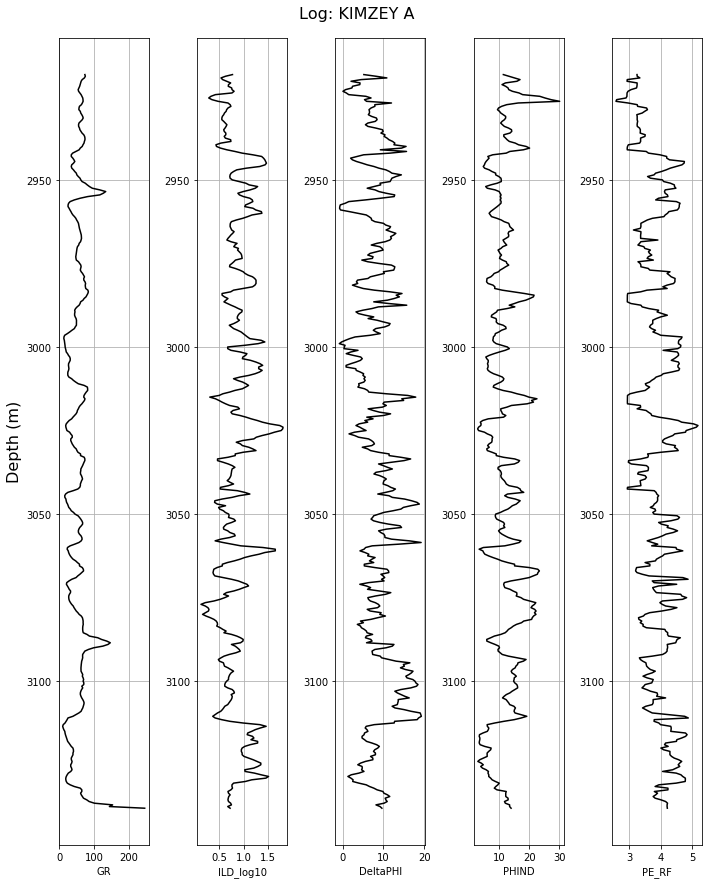

In [34]:
fig,axes = plt.subplots(ncols=5,figsize=(10,12))

for ax in axes:
    ax.invert_yaxis()

for i,ax in zip(cols_2,axes):
    ax.plot(PE_null[PE_null['Well Name']==well][i],PE_null[PE_null['Well Name']==well]['Depth'], c = 'black')
    ax.set_xlabel(i)
    ax.grid()
    
axes[0].set_ylabel('Depth (m)', fontsize=16)

fig.suptitle(f'Log: {well}', fontsize=16,y=1.02)
    
fig.tight_layout()

In [35]:
dataset['Pe_RF'] = arv.predict(pca.transform(dataset[cols])[:,:4])

In [36]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4149 entries, 0 to 4148
Data columns (total 16 columns):
Facies           4149 non-null int64
Formation        4149 non-null object
Well Name        4149 non-null object
Depth            4149 non-null float64
GR               4149 non-null float64
ILD_log10        4149 non-null float64
DeltaPHI         4149 non-null float64
PHIND            4149 non-null float64
PE               3232 non-null float64
NM_M             4149 non-null int64
RELPOS           4149 non-null float64
Labels_char      4149 non-null object
PHID             4149 non-null float64
PHIN             4149 non-null float64
Formation_num    4149 non-null float64
Pe_RF            4149 non-null float64
dtypes: float64(11), int64(2), object(3)
memory usage: 518.7+ KB


#### I have already predicted the PE using the Random Forest Regressor. Now it is time to classifie facies.

In [37]:
dataset.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Labels_char,PHID,PHIN,Formation_num,Pe_RF
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,Nonmarine fine siltstone,6.965,16.865,1.0,3.471580
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,Nonmarine fine siltstone,5.465,19.665,1.0,3.450657
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,Nonmarine fine siltstone,5.650,20.450,1.0,3.366156
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,Nonmarine fine siltstone,6.165,20.065,1.0,3.372080
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,Nonmarine fine siltstone,6.550,20.050,1.0,3.366156


In [70]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [39]:
dataset.columns

Index(['Facies', 'Formation', 'Well Name', 'Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS', 'Labels_char', 'PHID',
       'PHIN', 'Formation_num', 'Pe_RF'],
      dtype='object')

In [40]:
cols_3 = ['GR','ILD_log10','DeltaPHI','PHIND','Pe_RF','NM_M','PHID','PHIN']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(dataset[cols_3], dataset.Facies, test_size=0.33, random_state=42)

## Random Forest
#### Training the classification model using with the default parameters

In [46]:
r_forest_C = RandomForestClassifier(n_estimators=100)
arv_c = r_forest_C.fit(X_train, y_train)

#### Classification Report

In [48]:
print(classification_report(y_test, arv_c.predict(X_test)))

              precision    recall  f1-score   support

           1       0.81      0.57      0.67        83
           2       0.69      0.72      0.71       326
           3       0.66      0.71      0.68       249
           4       0.59      0.74      0.65        87
           5       0.42      0.33      0.37        84
           6       0.56      0.59      0.57       205
           7       0.88      0.41      0.56        54
           8       0.59      0.68      0.63       210
           9       0.93      0.60      0.73        72

    accuracy                           0.64      1370
   macro avg       0.68      0.59      0.62      1370
weighted avg       0.65      0.64      0.64      1370



#### Accuracy score in test data

In [50]:
accuracy_score(y_test, arv_c.predict(X_test))

0.6416058394160584

#### Accuracy score in training data

In [51]:
accuracy_score(y_train, arv_c.predict(X_train))

0.9985606333213386

In [52]:
dataset['Facies_RF'] = arv_c.predict(dataset[cols_3])

In [59]:
import matplotlib.colors as colors

In [60]:
facies_colors = ['xkcd:goldenrod', 'xkcd:orange','xkcd:sienna','xkcd:violet',
                 'xkcd:olive','xkcd:turquoise', "xkcd:yellowgreen", 'xkcd:indigo', 'xkcd:blue']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh','MS',  'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels to their respective colors
facies_color_map = {}
for i, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[i]
    

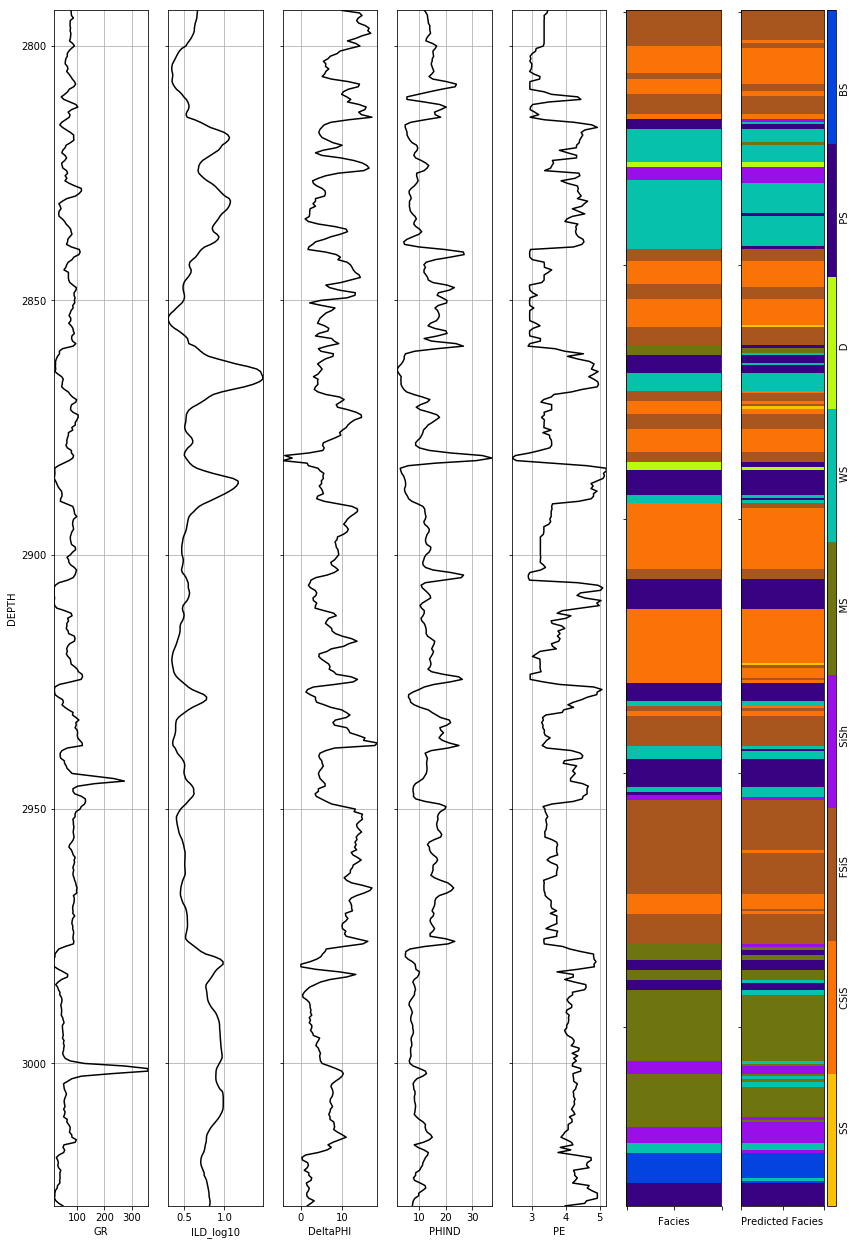

In [176]:
cluster2 = np.repeat(np.expand_dims(dataset[dataset['Well Name'] == 'SHRIMPLIN'].Facies_RF.values,1), 100, 1)
cluster_ = np.repeat(np.expand_dims(dataset[dataset['Well Name'] == 'SHRIMPLIN'].Facies.values,1), 100, 1)

fig, axes = plt.subplots(ncols=7, figsize = (12,18))

cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')

ztop=dataset[dataset['Well Name'] == 'SHRIMPLIN'].Depth.min()
zbot=dataset[dataset['Well Name'] == 'SHRIMPLIN'].Depth.max()

axes[0].plot(dataset[dataset['Well Name'] == 'SHRIMPLIN'].GR.values,
             dataset[dataset['Well Name'] == 'SHRIMPLIN'].Depth.values,
             c='black')

axes[1].plot(dataset[dataset['Well Name'] == 'SHRIMPLIN'].ILD_log10.values,
             dataset[dataset['Well Name'] == 'SHRIMPLIN'].Depth.values,
             c='black')

axes[2].plot(dataset[dataset['Well Name'] == 'SHRIMPLIN'].DeltaPHI.values,
             dataset[dataset['Well Name'] == 'SHRIMPLIN'].Depth.values,
             c='black')

axes[3].plot(dataset[dataset['Well Name'] == 'SHRIMPLIN'].PHIND.values,
             dataset[dataset['Well Name'] == 'SHRIMPLIN'].Depth.values,
             c='black')

axes[4].plot(dataset[dataset['Well Name'] == 'SHRIMPLIN'].Pe_RF.values,
             dataset[dataset['Well Name'] == 'SHRIMPLIN'].Depth.values,
             c='black')

axes[5].imshow(cluster_, interpolation='none', aspect='auto', cmap=cmap_facies,vmin=1,vmax=9)

im=axes[6].imshow(cluster2, interpolation='none', aspect='auto', cmap=cmap_facies,vmin=1,vmax=9)

for i in range(len(axes)-2):
    axes[i].set_ylim(ztop,zbot)
    axes[i].invert_yaxis()
    axes[i].grid()
    axes[i].locator_params(axis='x', nbins=3)
    
axes[0].set_xlabel("GR")
axes[0].set_ylabel('DEPTH')
axes[0].set_xlim(dataset[dataset['Well Name'] == 'SHRIMPLIN'].GR.min(),
                 dataset[dataset['Well Name'] == 'SHRIMPLIN'].GR.max())
axes[1].set_xlabel("ILD_log10")
axes[1].set_xlim(dataset[dataset['Well Name'] == 'SHRIMPLIN'].ILD_log10.min(),
                 dataset[dataset['Well Name'] == 'SHRIMPLIN'].ILD_log10.max())
axes[2].set_xlabel("DeltaPHI")
axes[2].set_xlim(dataset[dataset['Well Name'] == 'SHRIMPLIN'].DeltaPHI.min(),
                 dataset[dataset['Well Name'] == 'SHRIMPLIN'].DeltaPHI.max())
axes[3].set_xlabel("PHIND")
axes[3].set_xlim(dataset[dataset['Well Name'] == 'SHRIMPLIN'].PHIND.min(),
                 dataset[dataset['Well Name'] == 'SHRIMPLIN'].PHIND.max())
axes[4].set_xlabel("PE")
axes[4].set_xlim(dataset[dataset['Well Name'] == 'SHRIMPLIN'].Pe_RF.min(),
                 dataset[dataset['Well Name'] == 'SHRIMPLIN'].Pe_RF.max())
axes[5].set_xlabel('Facies')
axes[6].set_xlabel('Predicted Facies')

axes[1].set_yticklabels([])
axes[2].set_yticklabels([])
axes[3].set_yticklabels([])
axes[4].set_yticklabels([])
axes[5].set_yticklabels([])
axes[5].set_xticklabels([])
axes[6].set_yticklabels([])
axes[6].set_xticklabels([])

divider = make_axes_locatable(axes[6])
cax = divider.append_axes("right", size="10%", pad=0.05)
cbar=plt.colorbar(im, cax=cax)
cbar.set_label((35*' ').join([' SS ', 'CSiS', 'FSiS', 'SiSh', ' MS ', ' WS ', ' D  ', ' PS ', ' BS ']))
cbar.set_ticks(range(0,1))
cbar.set_ticklabels('')

fig.tight_layout()

## K-Nearest Neighbor

#### Training the classification model using with the default parameters

In [182]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [183]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [184]:
knn = KNeighborsClassifier()
knn.fit(scaler.transform(X_train), y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [186]:
print(classification_report(y_test, knn.predict(scaler.transform(X_test))))

              precision    recall  f1-score   support

           1       0.66      0.57      0.61        83
           2       0.67      0.71      0.69       326
           3       0.67      0.67      0.67       249
           4       0.52      0.72      0.60        87
           5       0.33      0.37      0.35        84
           6       0.56      0.58      0.57       205
           7       0.86      0.44      0.59        54
           8       0.64      0.60      0.62       210
           9       0.75      0.54      0.63        72

    accuracy                           0.62      1370
   macro avg       0.63      0.58      0.59      1370
weighted avg       0.63      0.62      0.62      1370



#### Accuracy score test data

In [188]:
accuracy_score(y_test, knn.predict(scaler.transform(X_test)))

0.6182481751824818

#### Accuracy score training data

In [190]:
accuracy_score(y_train, knn.predict(scaler.transform(X_train)))

0.7369557394746311

In [191]:
dataset['Facies_KNN'] = knn.predict(dataset[cols_3])

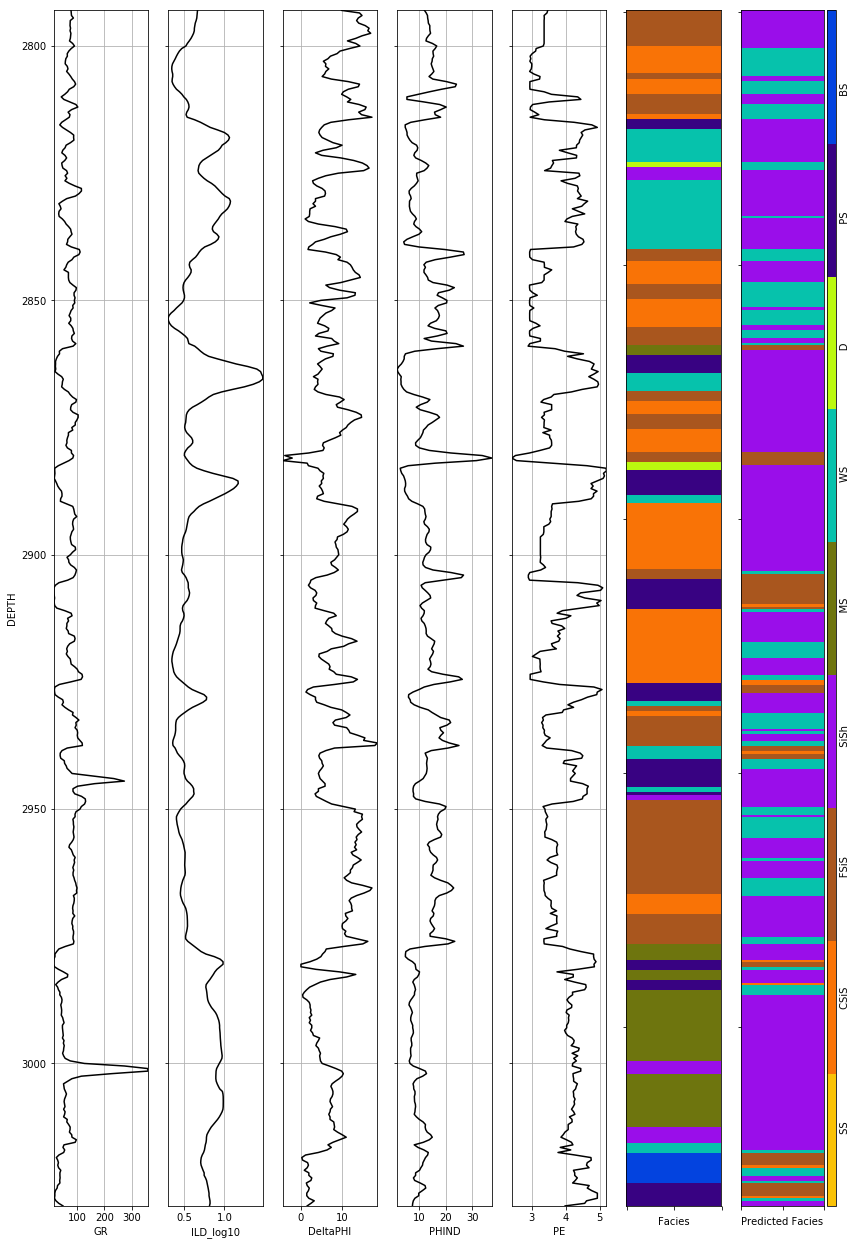

In [192]:
cluster2 = np.repeat(np.expand_dims(dataset[dataset['Well Name'] == 'SHRIMPLIN'].Facies_KNN.values,1), 100, 1)
cluster_ = np.repeat(np.expand_dims(dataset[dataset['Well Name'] == 'SHRIMPLIN'].Facies.values,1), 100, 1)

fig, axes = plt.subplots(ncols=7, figsize = (12,18))

cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')

ztop=dataset[dataset['Well Name'] == 'SHRIMPLIN'].Depth.min()
zbot=dataset[dataset['Well Name'] == 'SHRIMPLIN'].Depth.max()

axes[0].plot(dataset[dataset['Well Name'] == 'SHRIMPLIN'].GR.values,
             dataset[dataset['Well Name'] == 'SHRIMPLIN'].Depth.values,
             c='black')

axes[1].plot(dataset[dataset['Well Name'] == 'SHRIMPLIN'].ILD_log10.values,
             dataset[dataset['Well Name'] == 'SHRIMPLIN'].Depth.values,
             c='black')

axes[2].plot(dataset[dataset['Well Name'] == 'SHRIMPLIN'].DeltaPHI.values,
             dataset[dataset['Well Name'] == 'SHRIMPLIN'].Depth.values,
             c='black')

axes[3].plot(dataset[dataset['Well Name'] == 'SHRIMPLIN'].PHIND.values,
             dataset[dataset['Well Name'] == 'SHRIMPLIN'].Depth.values,
             c='black')

axes[4].plot(dataset[dataset['Well Name'] == 'SHRIMPLIN'].Pe_RF.values,
             dataset[dataset['Well Name'] == 'SHRIMPLIN'].Depth.values,
             c='black')

axes[5].imshow(cluster_, interpolation='none', aspect='auto', cmap=cmap_facies,vmin=1,vmax=9)

im=axes[6].imshow(cluster2, interpolation='none', aspect='auto', cmap=cmap_facies,vmin=1,vmax=9)

for i in range(len(axes)-2):
    axes[i].set_ylim(ztop,zbot)
    axes[i].invert_yaxis()
    axes[i].grid()
    axes[i].locator_params(axis='x', nbins=3)
    
axes[0].set_xlabel("GR")
axes[0].set_ylabel('DEPTH')
axes[0].set_xlim(dataset[dataset['Well Name'] == 'SHRIMPLIN'].GR.min(),
                 dataset[dataset['Well Name'] == 'SHRIMPLIN'].GR.max())
axes[1].set_xlabel("ILD_log10")
axes[1].set_xlim(dataset[dataset['Well Name'] == 'SHRIMPLIN'].ILD_log10.min(),
                 dataset[dataset['Well Name'] == 'SHRIMPLIN'].ILD_log10.max())
axes[2].set_xlabel("DeltaPHI")
axes[2].set_xlim(dataset[dataset['Well Name'] == 'SHRIMPLIN'].DeltaPHI.min(),
                 dataset[dataset['Well Name'] == 'SHRIMPLIN'].DeltaPHI.max())
axes[3].set_xlabel("PHIND")
axes[3].set_xlim(dataset[dataset['Well Name'] == 'SHRIMPLIN'].PHIND.min(),
                 dataset[dataset['Well Name'] == 'SHRIMPLIN'].PHIND.max())
axes[4].set_xlabel("PE")
axes[4].set_xlim(dataset[dataset['Well Name'] == 'SHRIMPLIN'].Pe_RF.min(),
                 dataset[dataset['Well Name'] == 'SHRIMPLIN'].Pe_RF.max())
axes[5].set_xlabel('Facies')
axes[6].set_xlabel('Predicted Facies')

axes[1].set_yticklabels([])
axes[2].set_yticklabels([])
axes[3].set_yticklabels([])
axes[4].set_yticklabels([])
axes[5].set_yticklabels([])
axes[5].set_xticklabels([])
axes[6].set_yticklabels([])
axes[6].set_xticklabels([])

divider = make_axes_locatable(axes[6])
cax = divider.append_axes("right", size="10%", pad=0.05)
cbar=plt.colorbar(im, cax=cax)
cbar.set_label((35*' ').join([' SS ', 'CSiS', 'FSiS', 'SiSh', ' MS ', ' WS ', ' D  ', ' PS ', ' BS ']))
cbar.set_ticks(range(0,1))
cbar.set_ticklabels('')

fig.tight_layout()